In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import glob
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


##Data cleaning and pre-processing 

In [3]:
neg_path="/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/Dataset-1/neg/*.txt"

pos_path="/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/Dataset-1/pos/*.txt"

current_dir = os.getcwd()
files_neg_text = glob.glob(neg_path)
files_pos_text =glob.glob (pos_path)

In [4]:
def get_data_label(files_texts,label):
  data_array=[]
  for name in files_texts:
    try:
        with open(name) as f:
            data_neg = f.read()
            data_array.append((data_neg ,label))
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise  
  return data_array

pos_data=get_data_label(files_pos_text,1)
neg_data=get_data_label(files_neg_text,0)
whole_data_array=pos_data+neg_data

In [5]:
# seprate the text and labels
all_text_arry=[]
label_all=[]
for i in range(len(whole_data_array)):
  all_text_arry.append(whole_data_array[i][0])
  label_all.append(whole_data_array[i][1])


In [6]:
# data cleaning 
def data_pre_processing(data):
  corpus = []
  for i in range(len(data)):
      review = re.sub('[^a-zA-Z]', ' ', data[i])
      review = re.sub("what's", "what is ", data[i])
      review = re.sub("\'ve", " have ", data[i])
      review = re.sub("can't", "cannot ", data[i])
      review = re.sub("n't", " not ", data[i])
      review = re.sub("i'm", "i am ", data[i])
      review = re.sub("\'ll", " will ", data[i])
      review = re.sub("he's", " he is ", data[i])
      review = re.sub("i've", " i have ", data[i])
      review = re.sub("--", "", data[i])
      review = review.lower()
      review = review.split()
      review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
      review = ' '.join(review)
      corpus.append(review)
  return corpus

process_text_data=data_pre_processing(all_text_arry)


## LSTM tarin with word2ve 

In [22]:
import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers.core import Dropout, Activation

In [15]:
import gensim
documents =process_text_data
sentences = [[word for word in document.lower().split()] for document in documents]
word_model = gensim.models.Word2Vec(sentences, size=50, min_count=1, 
                                    window=5)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('vocab_size',vocab_size)
print('emdedding_size',emdedding_size)

def token2word(token):
    return word_model.wv.index2word[token]

def word2token(word):
    try:
        return word_model.wv.vocab[word].index
    except KeyError:
        return 0

Result embedding shape: (46319, 50)
vocab_size 46319
emdedding_size 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Visualizing Word2Vec Embeddings with t-SNE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


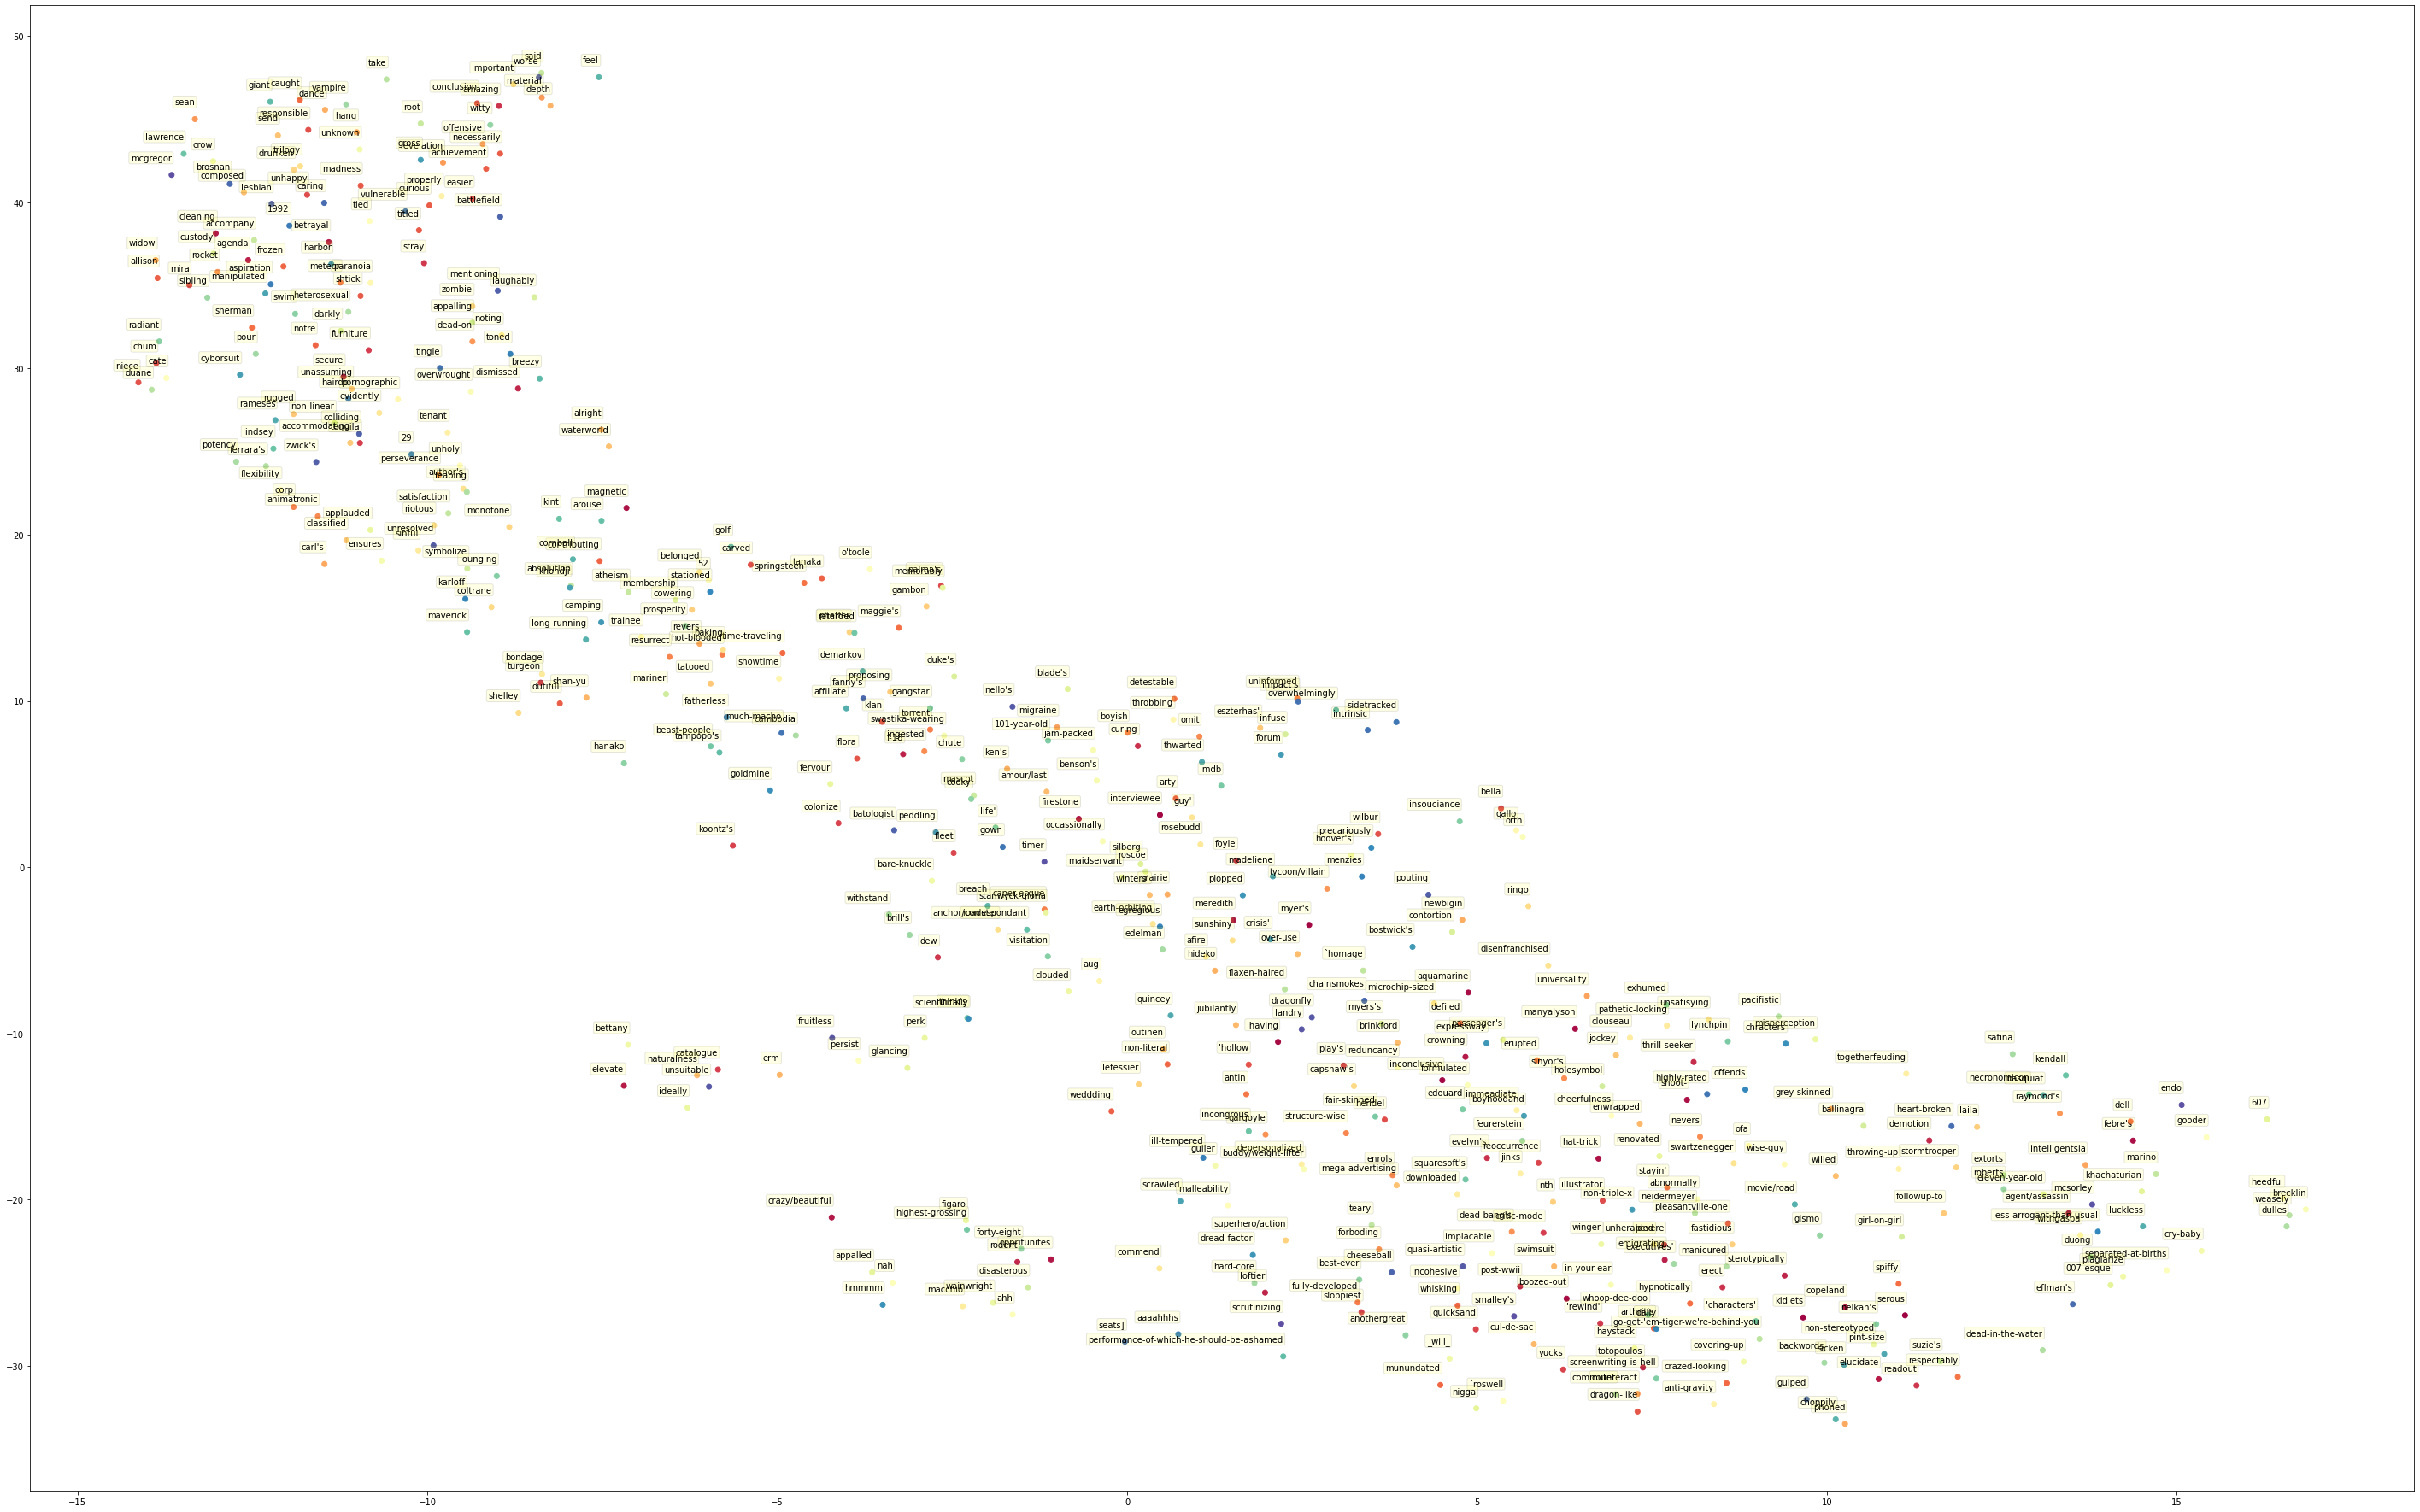

In [16]:

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import random
n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]
word_vecs = np.array([word_model[w] for w in random_w])
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(50, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))
    


In [17]:
# creating dataframe of traning data
df_text=pd.DataFrame(process_text_data)
df_label_all=pd.DataFrame(label_all)

In [18]:
# Sequences will be padded 
class SequenceIterator:
    def __init__(self, dataset):
        self.dataset = dataset        
    def __iter__(self):
        for news in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            news = news.lower()
            words = np.array([word2token(w) for w in news.split(' ')])        
            yield (words)
sequences = SequenceIterator(df_text)

set_x = []
for w in sequences:
    set_x.append(w)
# Padding sequences with 0.
set_x = pad_sequences(set_x,  padding='post', value=0)

In [19]:
import numpy as np
X_final=np.array(set_x)
y_final=np.array(label_all)
X_final.shape,y_final.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final, test_size=0.2, random_state=42)

In [23]:
#Model creation
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights],trainable=False))
model.add(LSTM(100))# 100 neuron 
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=5)

Epoch 1/20
321/321 [==============================] - 229s 714ms/step - loss: 0.7065 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 2/20
321/321 [==============================] - 229s 712ms/step - loss: 0.6975 - accuracy: 0.5019 - val_loss: 0.6939 - val_accuracy: 0.4950
Epoch 3/20
321/321 [==============================] - 233s 726ms/step - loss: 0.6972 - accuracy: 0.5037 - val_loss: 0.6935 - val_accuracy: 0.5050
Epoch 4/20
321/321 [==============================] - 236s 734ms/step - loss: 0.6964 - accuracy: 0.4931 - val_loss: 0.6950 - val_accuracy: 0.5050
Epoch 5/20
321/321 [==============================] - 231s 721ms/step - loss: 0.6953 - accuracy: 0.4738 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 6/20
321/321 [==============================] - 231s 719ms/step - loss: 0.6949 - accuracy: 0.4794 - val_loss: 0.6933 - val_accuracy: 0.5050
Epoch 7/20
321/321 [==============================] - 231s 721ms/step - loss: 0.6951 - accuracy: 0.5081 - val_loss: 0.6939 -

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

In [ ]:
y_pred=model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.49502487562189057

## LSTM train with word embedding 

In [ ]:
#define vocabulary size
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in process_text_data] 

In [ ]:
temp_split=[]
for item in process_text_data:
  temp_split.append(len(item.split()))
print(np.mean(temp_split))

351.7238285144566


In [ ]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)

In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(label_all)
X_final.shape,y_final.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final, test_size=0.2, random_state=42)

In [ ]:
#Model creation
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(50))# 100 neuron 
model.add(Dropout(0.3))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=30)

Epoch 1/10
54/54 [==============================] - 4s 36ms/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6895 - val_accuracy: 0.5075
Epoch 2/10
54/54 [==============================] - 1s 26ms/step - loss: 0.6538 - accuracy: 0.6048 - val_loss: 0.5559 - val_accuracy: 0.7239
Epoch 3/10
54/54 [==============================] - 1s 26ms/step - loss: 0.3013 - accuracy: 0.8962 - val_loss: 0.5766 - val_accuracy: 0.7214
Epoch 4/10
54/54 [==============================] - 1s 26ms/step - loss: 0.1095 - accuracy: 0.9742 - val_loss: 0.9284 - val_accuracy: 0.7164
Epoch 5/10
54/54 [==============================] - 1s 27ms/step - loss: 0.0146 - accuracy: 0.9972 - val_loss: 0.9210 - val_accuracy: 0.7239
Epoch 6/10
54/54 [==============================] - 1s 27ms/step - loss: 0.0231 - accuracy: 0.9949 - val_loss: 1.4086 - val_accuracy: 0.6990
Epoch 7/10
54/54 [==============================] - 2s 29ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.6472 - val_accuracy: 0.6990
Epoch 8/10
54

In [ ]:
y_pred=model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7313432835820896

## LSTM Train with pre-tarined Glove Embedding

In [28]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(process_text_data)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(process_text_data)
print(encoded_docs)

sent_length=40
padded_docs=pad_sequences(encoded_docs,padding='post',maxlen=sent_length)


In [30]:
import numpy as np
X_final=np.array(padded_docs)
y_final=np.array(label_all)
X_final.shape,y_final.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final, test_size=0.2, random_state=42)

In [31]:
# load the whole embedding into memory
embeddings_index = dict()
path_glove_fie='/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/glove.6B.100d.txt'
f = open(path_glove_fie)
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 400001 word vectors.


In [32]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [41]:
#Model creation
embedding_vector_features=100
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features, weights=[embedding_matrix],input_length=sent_length,trainable=False))
model.add(LSTM(100))# 100 neuron 
model.add(Dropout(0.3))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [42]:
trained_history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=5)

Epoch 1/20
321/321 [==============================] - 9s 23ms/step - loss: 0.7001 - accuracy: 0.5182 - val_loss: 0.6464 - val_accuracy: 0.6866
Epoch 2/20
321/321 [==============================] - 7s 21ms/step - loss: 0.6388 - accuracy: 0.6550 - val_loss: 0.5723 - val_accuracy: 0.7289
Epoch 3/20
321/321 [==============================] - 7s 21ms/step - loss: 0.5741 - accuracy: 0.7126 - val_loss: 0.5340 - val_accuracy: 0.7289
Epoch 4/20
321/321 [==============================] - 7s 21ms/step - loss: 0.5559 - accuracy: 0.7191 - val_loss: 0.5359 - val_accuracy: 0.7313
Epoch 5/20
321/321 [==============================] - 7s 21ms/step - loss: 0.4973 - accuracy: 0.7679 - val_loss: 0.5117 - val_accuracy: 0.7438
Epoch 6/20
321/321 [==============================] - 7s 21ms/step - loss: 0.4940 - accuracy: 0.7702 - val_loss: 0.5754 - val_accuracy: 0.7264
Epoch 7/20
321/321 [==============================] - 7s 21ms/step - loss: 0.4179 - accuracy: 0.8128 - val_loss: 0.5134 - val_accuracy: 0.7338

In [ ]:
import plotly.express as px
fig = px.line(
    trained_history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

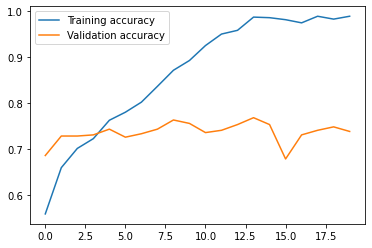

In [49]:
plt.plot(trained_history.history['accuracy'], label='Training accuracy')
plt.plot(trained_history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



[[147  52]
 [ 53 150]]


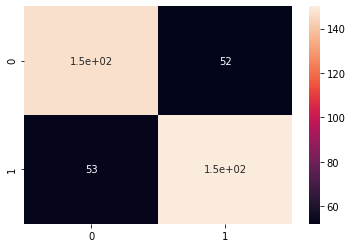

In [55]:
y_pred=model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

In [53]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test,y_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       199
           1       0.74      0.74      0.74       203

    accuracy                           0.74       402
   macro avg       0.74      0.74      0.74       402
weighted avg       0.74      0.74      0.74       402

